In [1]:
# %load_ext autoreload
# %autoreload 2

In [2]:
import torch
from rlaopt.solvers import PCGConfig
from rlaopt.preconditioners import NystromConfig
from rlaopt.kernels import KernelConfig
from scalable_gp_inference.bayes_opt.configs import BayesOptConfig, TSConfig
from scalable_gp_inference.bayes_opt.core import BayesOpt


In [3]:
device = torch.device("cuda:1")
dtype = torch.float32
seed = 3

noise_variance = 1e-6
lengthscale = 0.5
pcg_iters = 10
kernel_type = "matern32"
n_steps = 2

In [4]:
torch.set_default_dtype(dtype)
torch.manual_seed(seed)

In [5]:
kernel_config = KernelConfig(const_scaling=1.0, lengthscale=0.5)

In [6]:
precond_config = NystromConfig(rank=100, rho=1e-6)

In [7]:
solver_config = PCGConfig(device=device, max_iters=pcg_iters, precond_config=precond_config, atol=1e-12, rtol=1e-12)

In [8]:
bayes_config = BayesOptConfig(kernel_config=kernel_config, kernel_type=kernel_type, noise_variance=noise_variance)

In [9]:
ts_config = TSConfig()

In [10]:
opt = BayesOpt(bayes_config, device=device, dtype=dtype)

In [11]:
for _ in range(n_steps):
    opt.step(ts_config, solver_config)

In [12]:
opt.bo_state

BayesOptState(X=tensor([[0.8167, 0.2046, 0.1540,  ..., 0.4793, 0.9958, 0.1753],
        [0.8405, 0.2477, 0.3528,  ..., 0.3110, 0.3280, 0.6987],
        [0.3932, 0.3593, 0.3689,  ..., 0.6491, 0.6928, 0.8220],
        ...,
        [0.2336, 0.6829, 0.3219,  ..., 0.9858, 0.5706, 0.4936],
        [0.7304, 0.7388, 0.3159,  ..., 0.9424, 0.8987, 0.3391],
        [0.0000, 0.0000, 0.0747,  ..., 0.3552, 0.7572, 0.0650]],
       device='cuda:1'), y=tensor([ 0.5317,  0.5933, -0.5143,  ..., -0.5360,  2.6070,  2.5071],
       device='cuda:1'), rf_obj=<scalable_gp_inference.random_features.RandomFeatures object at 0x7f539f838a30>, w_true=tensor([-0.5162, -0.2217, -0.5594,  ...,  0.5392,  2.0194, -0.8012],
       device='cuda:1'), fn_max=4.613733768463135, fn_argmax=31773)

In [13]:
len(opt.bo_state)

52000

(array([ 13.,  66., 162., 331., 455., 484., 308., 125.,  44.,  12.]),
 array([-2.42711306, -1.79199612, -1.15687919, -0.52176225,  0.11335468,
         0.74847174,  1.38358855,  2.01870537,  2.65382242,  3.28893948,
         3.92405653]),
 <BarContainer object of 10 artists>)

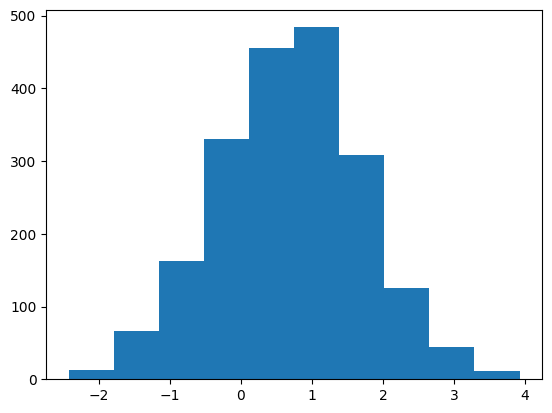

In [14]:
import matplotlib.pyplot as plt

plt.hist(opt.bo_state.y[50000:].cpu().numpy())

(array([3.3000e+01, 4.1400e+02, 3.3200e+03, 1.0879e+04, 1.6406e+04,
        1.2953e+04, 4.9760e+03, 9.2100e+02, 8.9000e+01, 9.0000e+00]),
 array([-3.83145785, -2.98693871, -2.14241958, -1.29790044, -0.4533813 ,
         0.39113784,  1.23565698,  2.08017612,  2.92469525,  3.76921439,
         4.61373377]),
 <BarContainer object of 10 artists>)

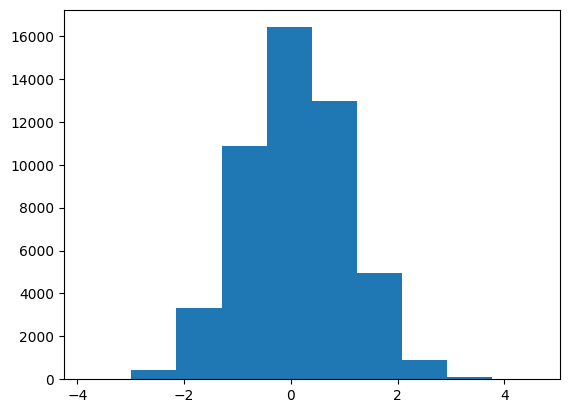

In [17]:
plt.hist(opt.bo_state.y[:50000].cpu().numpy())

In [15]:
print(opt.bo_state.y[:50000].max())

tensor(4.6137, device='cuda:1')


In [16]:
print(opt.bo_state.y[50000:].max())

tensor(3.9241, device='cuda:1')
